In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

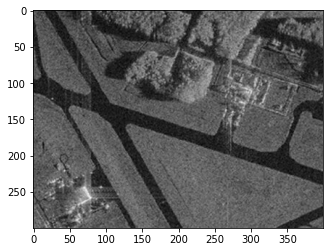

In [4]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [52]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [53]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [67]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
4
4
5
7
6
6
9
7
6
6
9
13
12
15
17
13
13
16
16
14
16
15
16
10
11
14
13
14
10
10
14
17
15
36
22
21
18
21
21
25
23
43
31
34
23
20
27
29
35
40
32
35
42
48
52
30
23
20
19
19
20
18
22
74
24
26
29
30
27
29
29
28
29
20
17
17
21
20
25
23
24
20
18
19
15
18
18
15
18
13
10
9
7
9
9
10
11
12
10
12
11
8
9
7
4
3
6
6
6
5
5
5
3
2
2
2
1
0


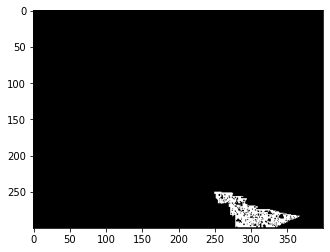

In [68]:
plt.imshow(mask, cmap="gray")

# K-means

In [7]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [8]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [10]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

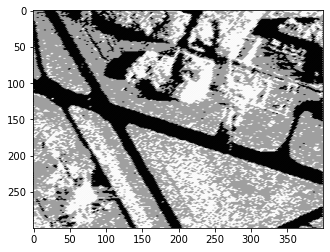

In [11]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [5]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

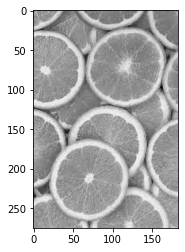

In [6]:
plt.imshow(image_gray, cmap="gray")

In [7]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

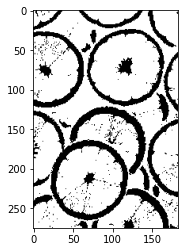

In [8]:
plt.imshow(thresh, cmap="gray")

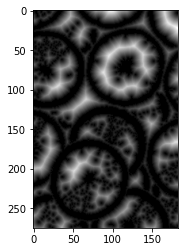

In [9]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

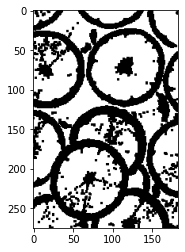

In [11]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [20]:
sure_fg = sure_fg.astype(np.uint8)

In [21]:
ret, markers = cv2.connectedComponents(sure_fg) 

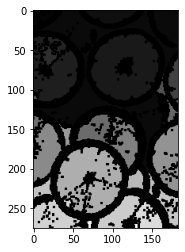

In [22]:
plt.imshow(markers, cmap="gray")

In [30]:
markers = cv2.watershed(image, markers)

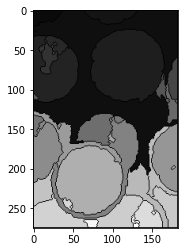

In [34]:
plt.imshow(markers, cmap="gray")

In [35]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

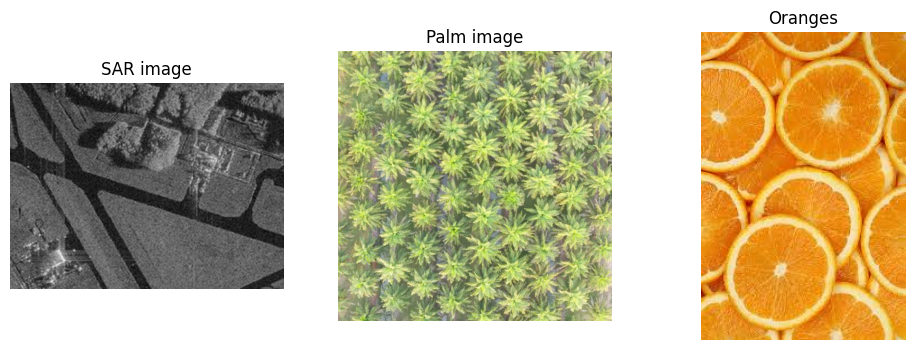

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, segmentation, feature, exposure, measure
from scipy import ndimage as ndi
from collections import deque

# ---- Загрузка изображений ----
sar_path = "sar_1.jpg"        # SAR изображение (для газона)
palm_path = "palm_1.JPG"      # Аэрофото пальм
oranges_path = "oranges_1.jpg" # Просто для проверки загрузки

sar = io.imread(sar_path, as_gray=True)
palm = io.imread(palm_path)
oranges = io.imread(oranges_path)

# нормализация SAR в диапазон [0..1]
sar = exposure.rescale_intensity(sar, in_range='image', out_range=(0,1))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sar, cmap="gray"); plt.title("SAR image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(palm); plt.title("Palm image"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(oranges); plt.title("Oranges"); plt.axis("off")
plt.show()

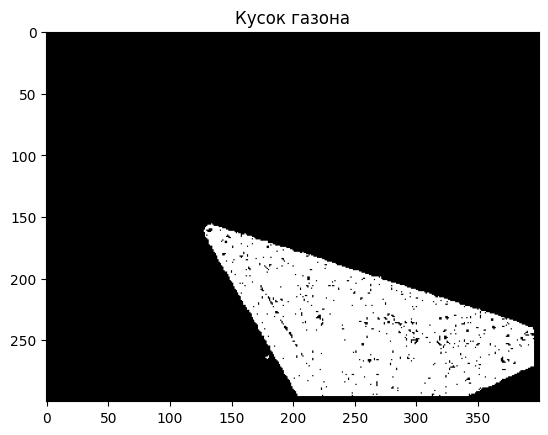

In [4]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def homo_average(img, mask, point, T):
    median_val = np.median(img[mask > 0])  
    if abs(median_val - img[point]) <= T:
        return True
    return False

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

seed_point = (250, 250)  
r = 4  
T = 18  

mask = region_growing(image_gray, seed_point, homo_average, r, T)

plt.imshow(mask, cmap="gray")
plt.title("Кусок газона")
plt.show()

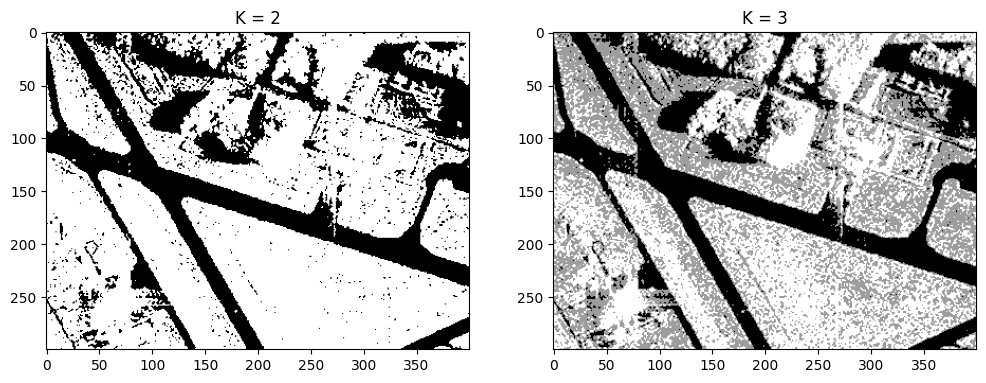

In [5]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


z = image_gray.reshape((-1, 1))  
z = np.float32(z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K_values = [2, 3]

plt.figure(figsize=(12,5))

for idx, K in enumerate(K_values, 1):
    ret, labels, centers = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()]
    segmented_image = segmented.reshape(image_gray.shape)
    
    plt.subplot(1, len(K_values), idx)
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"K = {K}")

plt.show()

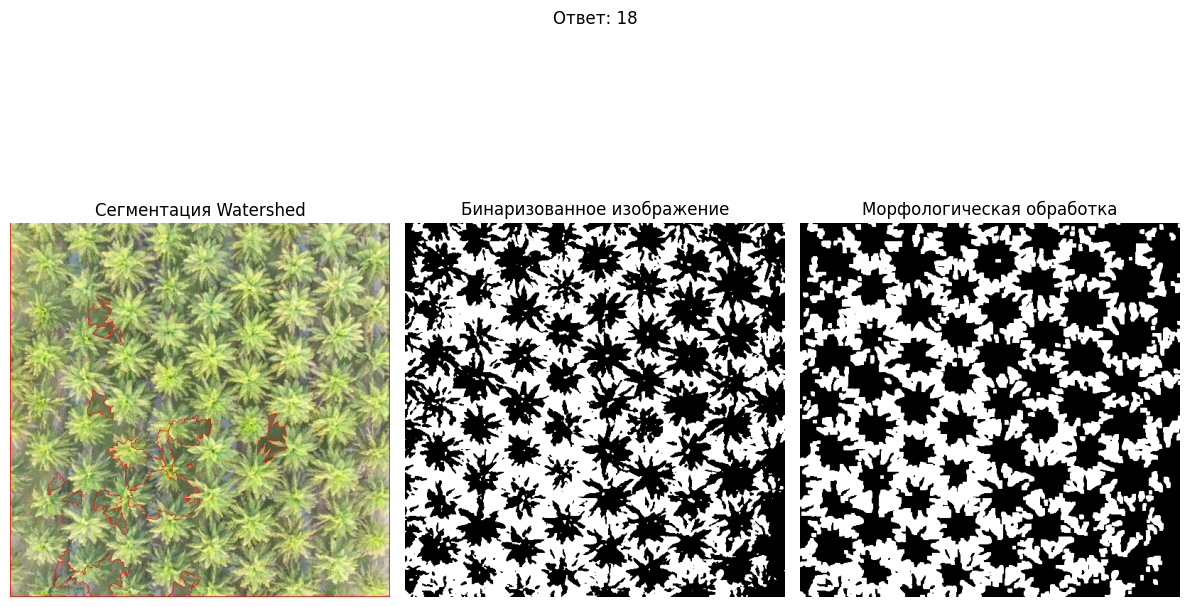

In [6]:
image = cv2.imread('palm_1.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(binary)
for cnt in contours:
    cv2.drawContours(mask, [cnt], -1, 255, -1)
dist_transform = cv2.distanceTransform(morph, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(mask, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]
num_trees = len(np.unique(markers)) - 1
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Сегментация Watershed")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Бинаризованное изображение")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(morph, cmap='gray')
plt.title("Морфологическая обработка")
plt.axis('off')
plt.suptitle(f'Ответ: {num_trees}')
plt.tight_layout()
plt.show()